In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import tempfile
from IPython.display import display, HTML
import numpy as np
import h5py
import csv
import os
import matplotlib.pyplot as plt
# TDGL imports
import tdgl
from tdgl.device.layer import Layer
from tdgl.device.polygon import Polygon
from tdgl.device.device import Device
from tdgl.solver.options import SolverOptions
from tdgl.solver.solve import solve
from tdgl.visualization import create_animation
import tdgl.solution.data as _data
from tdgl.geometry import box, circle

os.environ["OPENBLAS_NUM_THREADS"] = "1" # Limita el numero de hilos1 a 1. Evita que el código use muchos nucleos y sobrecargue el sistema

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 11
# os.chdir('C:/Users/kevin/Desktop/Tesis/Tesis/Segunda calcinada/Histeresis/datos/Keven/Fe/simulaciones/Temperatura')
# print("Directorio actual:", os.getcwd())

""""def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)"""
#Función que hace un video a partir de la solución 
def make_video_from_solution(solution, **kwargs):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(h5file, **kwargs)
            video = anim.to_html5_video()
        return HTML(video)

        
#Función Potencial vectorial para un campo uniforme Hz en +z.
def vector_potential(x, y, z, t=0):
    """
    Args
    ----
    x, y, z : np.ndarray    (de la misma longitud N)
    t       : float         (ignoramos porque el campo es estático)

    Returns
    -------
    A : np.ndarray de shape (N, 2)   →  [Ax, Ay]
    """
    Hz = 0.2                      # Magnitud del campo externo (adimensional)
    Ax = -0.5 * Hz * y            #  -Hz y / 2
    Ay =  0.5 * Hz * x            #   Hz x / 2
    return np.column_stack((Ax, Ay))     # shape (N, 2)

# Densidad de corriente
def current_density(t):
    return {
        "left": 200,
        "right": -200}

USE_TEMPDIR = True
SAVE = False
MAKE_ANIMATIONS = True
if USE_TEMPDIR:
    tempdir = tempfile.TemporaryDirectory()
    output_path = tempdir.name
else:
    output_path = "."

Constructing Voronoi polygons:   0%|          | 0/407 [00:00<?, ?it/s]

Constructing Voronoi polygons: 100%|██████████| 407/407 [00:00<00:00, 958.66it/s] 


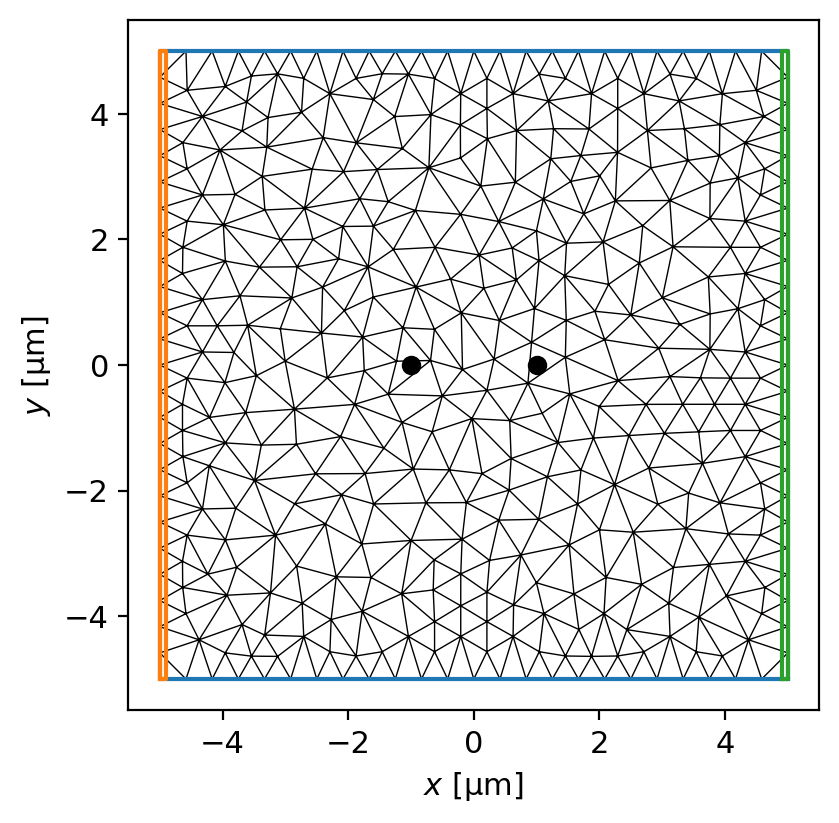

In [2]:
# ─────── Capa superconductora (unidades adimensionales en ξ) ────────────────────────────
COHERENCE_LENGTH = 1.0  # ξ
LONDON_LAMBDA = 2.0     # λ  (κ=λ/ξ → κ=2)
THICKNESS = 1.0         # Espesor d ≪ ξ
U = 1.0                # Parámetro u
GAMMA = 10.0            # Parámetro γ
Z0 = 0.0                # Coordenada z de la capa
probe_points = [
    [-1.0, 0.0],    # Punto 1
    [1.0, 0.0]     # Punto 2 (dentro del radio RADIUS=40)
]

# ─────── Solver y tiempo ───────────────────────────────────────────────────────────────
TOTAL_TIME = 60.0       # Tiempo total de simulación (adimensional)
DT_INIT = 0.001          # Paso de tiempo inicial
dt_max = 0.01           # Paso máximo (si adaptive=True)
ADAPTIVE = False         #  paso adaptativo
SAVE_EVERY = 200         # Guardar cada n pasos
o_output = "box.h5"  # Nombre de salida HDF5


# ─────── Geometría ───────────────────────────────────────────────────────────────
length, width  = 10 , 10
points = box(length, width)
film = Polygon(name="film", points=points)
eps=length/100


# ─────── Crear la capa superconductora ──────────────────────────────────────────
t_layer = Layer(
    london_lambda=LONDON_LAMBDA,
    coherence_length=COHERENCE_LENGTH,
    thickness=THICKNESS,
    u=U,
    gamma=GAMMA,
    z0=Z0
)


# ─────── Definir terminales ────────────────────────────────────────────────────────

#  Cálculo de los límites de la película 

xmin, xmax = -length/2, length/2
ymin, ymax = -width/2,  width/2

# Definir terminales con flujo de corriente constante
left_coords = np.array([
    [xmin,      ymin],
    [xmin+eps,  ymin],
    [xmin+eps,  ymax],
    [xmin,      ymax],
])
term_left = Polygon(
    name="left",
    points=left_coords,
    mesh=False,

)

right_coords = np.array([
    [xmax-eps,  ymin],
    [xmax,      ymin],
    [xmax,      ymax],
    [xmax-eps,  ymax],
])
term_right = Polygon(
    name="right",
    points=right_coords,
    mesh=False,
  
)
# ─────── Montar el Device ────────────────────────────────────────────────────────

device = Device(
    name="box",
    layer=t_layer,
    film=film,
    holes=[],
    terminals=[term_left, term_right],
    probe_points=probe_points,
    length_units="um"
)
device.make_mesh()

# ─────── Configuración del solver ──────────────────────────────────────────────────
options = SolverOptions(
    solve_time=TOTAL_TIME,
    skip_time=0.0,
    dt_init=DT_INIT,
    dt_max=dt_max,
    adaptive=ADAPTIVE,
    save_every=SAVE_EVERY,
    output_file=o_output,
)
fig, ax = device.plot(mesh=True, legend=False)

In [3]:
# ─────── Ejecutar simulación ─────────────────────────────────────────────────
solution = solve(
    device=device,
    options=options,
    applied_vector_potential=vector_potential,
    terminal_currents=current_density,
    disorder_epsilon=1.0
)
# ─────── Crear animación ────────────────────────────────────────────────────────

file="box.h5"

if USE_TEMPDIR:
    tempdir = tempfile.TemporaryDirectory()
    output_path = tempdir.name
else:
    output_path = "."

if MAKE_ANIMATIONS:
    video = make_video_from_solution(
        solution,
        quantities=["order_parameter", "phase"],
        dpi=100,
        fps=100,
        title_off=True,
        axes_off=True,
        max_frame=600,
        max_cols=1,
        figure_kwargs=dict(figsize=(4.5, 6)),
    )
    print("video terminado")
    display(video)
else: 
    create_animation(
    input_file=file,
    output_file="box-animation.GIF",
    quantities=["order_parameter", "vorticity"],
    fps=60,
    dpi=300
    )
    print(f"Animación guardada en {file}")

if USE_TEMPDIR:
    tempdir.cleanup()

# if SAVE:
#     fig.set_size_inches(3, 1)
#     fig.savefig(os.path.join(image_path, "logo-transparent-small.png"), dpi=300)
#     fig.set_size_inches(4, 3)
#     fig.savefig(os.path.join(image_path, "logo-transparent-large.png"), dpi=300, bbox_inches="tight")

Output file already exists. Renaming to box-1.h5.
Simulating:   0%|          | 0/60.0 [00:00<?, ?tau/s ]

Simulating: 100%|█████████▉| 60/60.0 [00:50<00:00,  1.19tau/s ]


video terminado
